# Economic Feasability Analysis for a Commercial Solar Facility in China

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('notebook', font_scale=1.5)
palette = sns.color_palette("Set2", 10)

### I. Use solar irradiation data to generate 8760

In [2]:
# Constants
AREA = 104167
EFFICIENCY = 0.17

In [3]:
# Read in daily solar radiation data
solardaily = pd.read_csv('chinasolar.csv')
solardaily.columns = ['Date', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
solardaily.head()

,Date,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,12.07,15.56,13.79,25.74,18.64,11.85,17.43,15.34,11.11,11.23,19.57,10.29
1,2,16.53,3.60,21.54,26.48,11.56,8.58,7.60,11.37,11.18,20.73,19.35,14.54
2,3,8.57,9.70,18.13,24.28,16.23,21.85,11.00,11.04,8.61,21.62,17.73,14.34
3,4,13.64,15.26,16.28,23.93,3.92,9.44,11.11,7.55,5.63,9.90,10.45,16.00
4,5,8.29,12.97,11.11,20.50,17.22,18.70,17.94,21.49,10.46,15.27,15.83,8.11


In [4]:
# Read in hourly data for one day
solarday = pd.read_csv('solaroneday2.csv')
solarday = solarday[solarday['Global Solar Radiation'] < 3000]
solarday.head()

,Hour,Global Solar Radiation,Radiation out of 1
0,1,0,0.0
1,2,0,0.0
2,3,0,0.0
3,4,0,0.0
4,5,0,0.0


In [5]:
# Create 8760 table
solar8760 = pd.DataFrame(columns=['Month', 'Day', 'Hour', 'Radiation'])
for month in solardaily.drop('Date', axis=1).columns.values:
    for day in solardaily['Date'].values:
        totalhours = solardaily.iloc[day - 1][month]
        if not np.isnan(totalhours):
            for hour in solarday.index.values:
                thishour = solarday['Radiation out of 1'][hour] * totalhours
                solar8760 = solar8760.append({'Month':month, 'Day':day, 'Hour':hour, 'Radiation':thishour}, 
                                             ignore_index = True)
solar8760.head()

,Month,Day,Hour,Radiation
0,Jan,1,0,0.0
1,Jan,1,1,0.0
2,Jan,1,2,0.0
3,Jan,1,3,0.0
4,Jan,1,4,0.0


In [6]:
# Calculate energy produced in each hour
solar8760['Energy'] = solar8760['Radiation'].map(lambda x: x*AREA*EFFICIENCY/3600)

In [7]:
# Add numerical monthly tag
monthsnums = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
solar8760['monthnum'] = solar8760['Month'].map(lambda x: monthsnums[x])

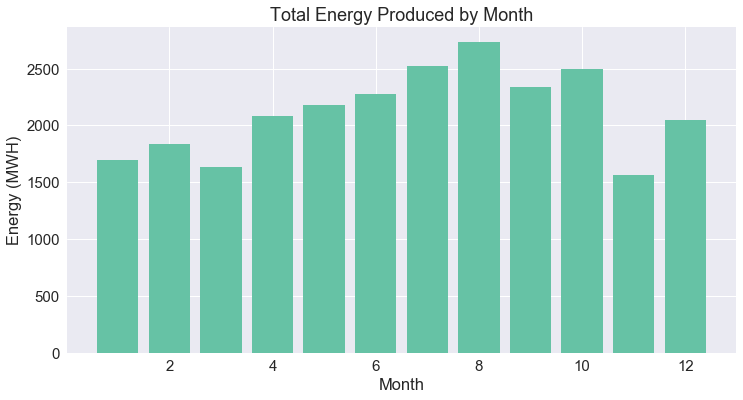

In [8]:
# Graph of energy produced monthly 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(1, 13), solar8760.groupby('monthnum').agg('sum')['Energy'], color=palette[0])
plt.title('Total Energy Produced by Month')
plt.xlabel('Month')
plt.ylabel('Energy (MWH)')
plt.show()

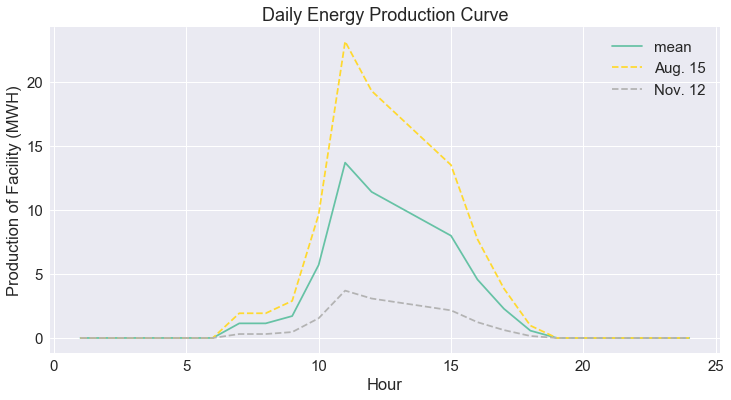

In [33]:
# Graph of average energy produced in each hour
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 25), solar8760.groupby('Hour').agg('mean')['Energy'], color=palette[0], label='mean')
plt.plot(np.arange(1, 25), solar8760[(solar8760['Month'] == 'Aug') & (solar8760['Day'] == 15)]['Energy'], '--', color=palette[5], label='Aug. 15')
plt.plot(np.arange(1, 25), solar8760[(solar8760['Month'] == 'Nov') & (solar8760['Day'] == 12)]['Energy'], '--', color=palette[7], label='Nov. 12')
plt.title('Daily Energy Production Curve')
plt.xlabel('Hour')
plt.ylabel('Production of Facility (MWH)')
plt.legend(loc='best')
plt.show()

### II. Use demand data to calculate energy going to self-consumption vs. the grid

In [10]:
# Get demand in each hour
demand = pd.read_csv('prologisdemand2.csv')
solar8760['Demand'] = solar8760['Hour'].map(lambda x: demand.iloc[x]['Demand'])
solar8760.head(n=5)

,Month,Day,Hour,Radiation,Energy,monthnum,Demand
0,Jan,1,0,0.0,0.0,1,0.300256
1,Jan,1,1,0.0,0.0,1,0.300256
2,Jan,1,2,0.0,0.0,1,0.300256
3,Jan,1,3,0.0,0.0,1,0.300256
4,Jan,1,4,0.0,0.0,1,0.300256


In [11]:
# Calculate energy going to self-consumption, energy bought from grid, excess energy
solar8760['Self Consumed'] = solar8760.apply(lambda row: min(row['Energy'], row['Demand']), axis=1)
solar8760['Excess'] = solar8760.apply(lambda row: max(row['Energy'] - row['Demand'], 0), axis=1)
solar8760['Debt'] = solar8760.apply(lambda row: max(row['Demand'] - row['Energy'], 0), axis=1)
solar8760.head()

,Month,Day,Hour,Radiation,Energy,monthnum,Demand,Self Consumed,Excess,Debt
0,Jan,1,0,0.0,0.0,1,0.300256,0.0,0.0,0.300256
1,Jan,1,1,0.0,0.0,1,0.300256,0.0,0.0,0.300256
2,Jan,1,2,0.0,0.0,1,0.300256,0.0,0.0,0.300256
3,Jan,1,3,0.0,0.0,1,0.300256,0.0,0.0,0.300256
4,Jan,1,4,0.0,0.0,1,0.300256,0.0,0.0,0.300256


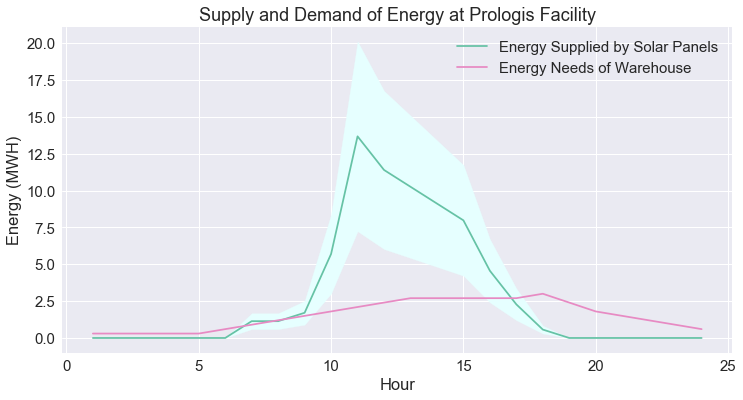

In [34]:
# Graph of average daily supply vs. demand
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 25), solar8760.groupby('Hour').agg('mean')['Energy'], color=palette[0], label='Energy Supplied by Solar Panels')
plt.plot(np.arange(1, 25), solar8760.groupby('Hour').agg('mean')['Demand'], color=palette[3], label='Energy Needs of Warehouse')
plt.fill_between(np.arange(1, 25), solar8760.groupby('Hour').agg('mean')['Energy'] + solar8760.groupby('Hour').agg(np.std)['Energy'], 
                 solar8760.groupby('Hour').agg('mean')['Energy'] - solar8760.groupby('Hour').agg(np.std)['Energy'], color='#e6ffff')
plt.legend(loc='best')
plt.xlabel('Hour')
plt.ylabel('Energy (MWH)')
plt.title("Supply and Demand of Energy at Prologis Facility")
plt.show()

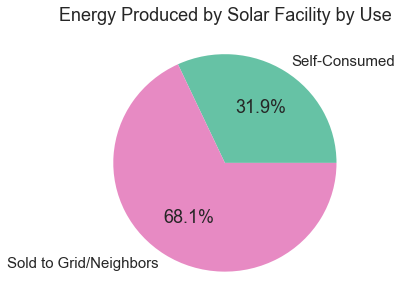

In [13]:
# Pie chart of energy by sale method
plt.figure(figsize=(5, 5))
totalselfconsumed = solar8760.agg('sum')['Self Consumed']
totalsold = solar8760.agg('sum')['Excess']
colors = [palette[0], palette[3]]
pielabels = ['Self-Consumed', 'Sold to Grid/Neighbors']
plt.pie([totalselfconsumed, totalsold], labels=pielabels, colors=colors, autopct='%1.1f%%',)
plt.title('Energy Produced by Solar Facility by Use')
plt.show()

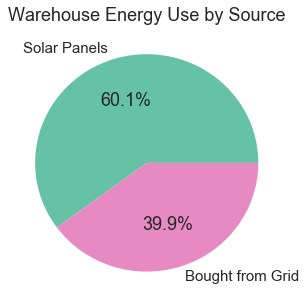

In [14]:
# Pie chart of prologis needs by energy source
plt.figure(figsize=(5, 5))
totalselfconsumed = solar8760.agg('sum')['Self Consumed']
totalsold = solar8760.agg('sum')['Debt']
pielabels = ['Solar Panels', 'Bought from Grid']
colors = [palette[0], palette[3]]
plt.pie([totalselfconsumed, totalsold], labels=pielabels, colors=colors, autopct='%1.1f%%',)
plt.title('Warehouse Energy Use by Source')
plt.show()

### III. Use prices of energy and FITS to calculate revenues and profits

In [15]:
# Constants
FIT = 58
GRID_CLEAN = 118.34
GRID_COAL = 71.84
RETAIL = 63.11 + 47.34 + 6
COST = 113
sell_to_neighbors_fit = FIT - .1*FIT
neighbors_retail = RETAIL - .2*RETAIL

In [16]:
# Calculate revenues from self consumption and selling excess to grid
solar8760['Self Consumption Revenue'] = solar8760['Self Consumed'].map(lambda x: x * (FIT + RETAIL))
solar8760['Grid Sale Revenue'] = solar8760['Excess'].map(lambda x: x * (FIT + GRID_COAL))
solar8760['Sell to Neighbors Revenue'] = solar8760['Excess'].map(lambda x: x * (sell_to_neighbors_fit + neighbors_retail))
solar8760['Total Revenue - Grid Strategy'] = solar8760['Self Consumption Revenue'] + solar8760['Grid Sale Revenue']
solar8760['Total Revenue - Neighbors Strategy'] = solar8760['Self Consumption Revenue'] + solar8760['Sell to Neighbors Revenue']

In [17]:
print("Total Revenue (Grid Strategy): " + str(solar8760.agg('sum')['Total Revenue - Grid Strategy']))
print("Total Revenue: (Neighbors Strategy)" + str(solar8760.agg('sum')['Total Revenue - Neighbors Strategy']))
print("Revenue per MWH (Grid Strategy): " + str(solar8760.agg('sum')['Total Revenue - Grid Strategy']/solar8760.agg('sum')['Energy']))
print("Revenue per MWH (Neighbors Strategy): " + str(solar8760.agg('sum')['Total Revenue - Neighbors Strategy']/solar8760.agg('sum')['Energy']))

Total Revenue (Grid Strategy): 3658808.1732378225
Total Revenue: (Neighbors Strategy)3927164.538041681
Revenue per MWH (Grid Strategy): 144.0758602183022
Revenue per MWH (Neighbors Strategy): 154.64314668797178


In [18]:
solar8760.describe()

,Radiation,Energy,monthnum,Demand,Self Consumed,Excess,Debt,Self Consumption Revenue,Grid Sale Revenue,Sell to Neighbors Revenue,Total Revenue - Grid Strategy,Total Revenue - Neighbors Strategy
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.589342,2.898974,6.526027,1.538812,0.925115,1.973859,0.613697,161.386342,256.285824,286.920112,417.672166,448.306454
std,0.993016,4.884643,3.448048,0.942847,1.092271,4.108342,0.755056,190.546666,533.427167,597.188640,672.278811,734.656303
min,0.000000,0.000000,1.000000,0.300256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,4.000000,0.600512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.006148,0.030240,7.000000,1.501280,0.030240,0.000000,0.300256,5.275322,0.000000,0.000000,5.275322,5.275322
75%,0.714467,3.514462,10.000000,2.477113,2.101793,1.191767,0.900768,366.657734,154.739009,173.235230,571.819443,586.688369
max,5.319344,26.165840,12.000000,3.002561,2.702305,24.064047,2.942082,471.417086,3124.475859,3497.949868,3491.133592,3864.607601


In [19]:
# Add cost and profit
solar8760['Cost'] = solar8760['Energy']*COST
solar8760['Profit Grid'] = solar8760['Total Revenue - Grid Strategy'] - solar8760['Cost']
solar8760['Profit Neighbors'] = solar8760['Total Revenue - Neighbors Strategy'] - solar8760['Cost']
print("Total Yearly Profit (selling to neighbors): " + str(solar8760.agg('sum')['Profit Neighbors']))
print("Total Yearly Profit (selling to grid): " + str(solar8760.agg('sum')['Profit Grid']))

Total Yearly Profit (selling to neighbors): 1057528.2023680524
Total Yearly Profit (selling to grid): 789171.8375641954


### IV. Sensitivty Analysis (Sensitivity to Changes in Market Prices)

In [20]:
def sensitivityanalysis(fit, retail, grid_coal):
    sell_to_neighbors_fit = fit - .1*fit
    neighbors_retail = retail - .1*retail
    solar8760s = solar8760
    # Calculate revenues from self consumption and selling excess to grid
    solar8760s['Self Consumption Revenue'] = solar8760s['Self Consumed'].map(lambda x: x * (fit + retail))
    solar8760s['Grid Sale Revenue'] = solar8760s['Excess'].map(lambda x: x * (fit + grid_coal))
    solar8760s['Sell to Neighbors Revenue'] = solar8760s['Excess'].map(lambda x: x * (sell_to_neighbors_fit + neighbors_retail))
    solar8760s['Total Revenue - Grid Strategy'] = solar8760s['Self Consumption Revenue'] + solar8760s['Grid Sale Revenue']
    solar8760s['Total Revenue - Neighbors Strategy'] = solar8760s['Self Consumption Revenue'] + solar8760s['Sell to Neighbors Revenue']
    
    revenue_grid = solar8760s.agg('sum')['Total Revenue - Grid Strategy']/solar8760s.agg('sum')['Energy']
    revenue_neighbors = solar8760s.agg('sum')['Total Revenue - Neighbors Strategy']/solar8760s.agg('sum')['Energy']

    # Add cost and profit
    solar8760s['Cost'] = solar8760s['Energy']*COST
    solar8760s['Profit Grid'] = solar8760s['Total Revenue - Grid Strategy'] - solar8760s['Cost']
    solar8760s['Profit Neighbors'] = solar8760s['Total Revenue - Neighbors Strategy'] - solar8760s['Cost']
    profit_neighbors = solar8760s.agg('sum')['Profit Neighbors']/solar8760s.agg('sum')['Energy']
    profit_grid = solar8760.agg('sum')['Profit Grid']/solar8760s.agg('sum')['Energy']
    
    return revenue_neighbors, revenue_grid, profit_neighbors, profit_grid

#### A. Sensitivity to FIT

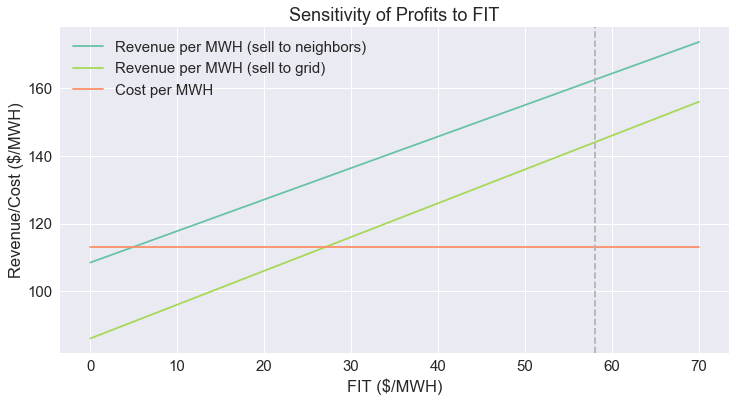

In [21]:
rns = []
rgs = []
costs = []
for f in np.arange(0, 80, 10):
    rn, rg, pn, pg = sensitivityanalysis(f, RETAIL, GRID_COAL)
    rns.append(rn)
    rgs.append(rg)
    costs.append(COST)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, 80, 10), rns, label='Revenue per MWH (sell to neighbors)', color=palette[0])
plt.plot(np.arange(0, 80, 10), rgs, label='Revenue per MWH (sell to grid)', color=palette[4])
plt.plot(np.arange(0, 80, 10), costs, label='Cost per MWH', color=palette[1])
plt.axvline(x=FIT, color=palette[7], linestyle='dashed')
plt.legend(loc='best')
plt.xlabel('FIT ($/MWH)')
plt.ylabel('Revenue/Cost ($/MWH)')
plt.title('Sensitivity of Profits to FIT')
plt.show()

#### B. Sensitivity to coal benchmark price

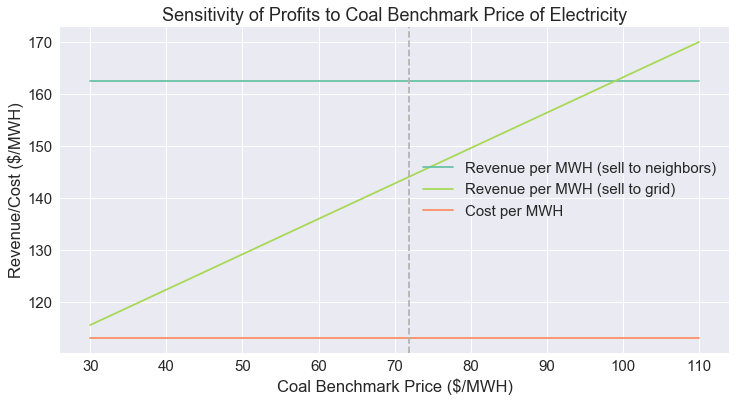

In [22]:
rns = []
rgs = []
costs = []
for gc in np.arange(30, 120, 10):
    rn, rg, pn, pg = sensitivityanalysis(FIT, RETAIL, gc)
    rns.append(rn)
    rgs.append(rg)
    costs.append(COST)
    
plt.figure(figsize=(12, 6))
plt.plot(np.arange(30, 120, 10), rns, label='Revenue per MWH (sell to neighbors)', color=palette[0])
plt.plot(np.arange(30, 120, 10), rgs, label='Revenue per MWH (sell to grid)', color=palette[4])
plt.plot(np.arange(30, 120, 10), costs, label='Cost per MWH', color=palette[1])
plt.axvline(x=GRID_COAL, color=palette[7], linestyle='dashed')
plt.legend(loc='best')
plt.xlabel('Coal Benchmark Price ($/MWH)')
plt.ylabel('Revenue/Cost ($/MWH)')
plt.title('Sensitivity of Profits to Coal Benchmark Price of Electricity')
plt.show()

#### C. Sensitivity to retail commercial price

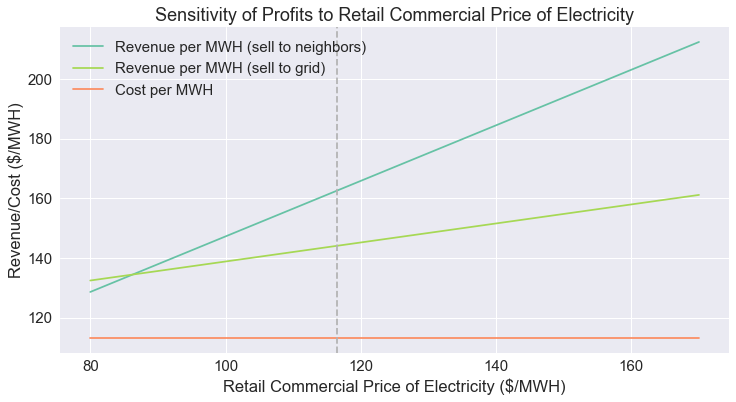

In [23]:
rns = []
rgs = []
costs = []
for r in np.arange(80, 180, 10):
    rn, rg, pn, pg = sensitivityanalysis(FIT, r, GRID_COAL)
    rns.append(rn)
    rgs.append(rg)
    costs.append(COST)
    
plt.figure(figsize=(12, 6))
plt.plot(np.arange(80, 180, 10), rns, label='Revenue per MWH (sell to neighbors)', color=palette[0])
plt.plot(np.arange(80, 180, 10), rgs, label='Revenue per MWH (sell to grid)', color=palette[4])
plt.plot(np.arange(80, 180, 10), costs, label='Cost per MWH', color=palette[1])
plt.axvline(x=RETAIL, color=palette[7], linestyle='dashed')
plt.legend(loc='best')
plt.xlabel('Retail Commercial Price of Electricity ($/MWH)')
plt.ylabel('Revenue/Cost ($/MWH)')
plt.title('Sensitivity of Profits to Retail Commercial Price of Electricity')
plt.show()

### V. Adding a Battery

In [24]:
# Constants
BATTERY_CAP = .21
BATTERY_MAXRATE = .05
BATTERY_COST = .81
ROUNDTRIP_EFFICIENCY = 0.89

In [25]:
def chargebattery(battery_cap, battery_maxrate, battery_previous, excess, debt):
    #print(min([battery_cap, battery_previous + excess]))
    if excess > 0:
        return min([battery_cap, battery_previous + excess, battery_previous + battery_maxrate])
    elif debt > 0:
        return max([battery_previous - debt, 0, battery_previous - battery_maxrate])

costs = []
revenues_grid = []
profits_grid = []
revenues_neighbors = []
profits_neighbors = []

for num_batteries in range(0, 60, 2):
    print(num_batteries)
    solarstorage8760 = solar8760
    solarstorage8760['battery'] = 0
    solarstorage8760['battery_consumption'] = 0
    solarstorage8760['battery_storage'] = 0
    for i, row in solarstorage8760.iterrows():
        if i > 0:
            battery_previous = solarstorage8760['battery'][i-1]
            battery_now = chargebattery(BATTERY_CAP*num_batteries, BATTERY_MAXRATE*num_batteries, battery_previous, row['Excess'], row['Debt'])
            solarstorage8760.iloc[i, solarstorage8760.columns.get_loc('battery')] = battery_now
            solarstorage8760.iloc[i, solarstorage8760.columns.get_loc('battery_consumption')] = max(0, battery_previous - battery_now)
            solarstorage8760.iloc[i, solarstorage8760.columns.get_loc('battery_storage')] = max(0, (battery_now - battery_previous)*ROUNDTRIP_EFFICIENCY)
    solarstorage8760['excess_with_battery'] = solarstorage8760['Excess'] - solarstorage8760['battery_storage']
    solarstorage8760['debt_with_battery'] = solarstorage8760['Debt'] - solarstorage8760['battery_consumption']
    solarstorage8760['self_consumed_with_battery'] = solarstorage8760['Self Consumed'] + solarstorage8760['battery_consumption']
    solarstorage8760['self_consumption_rev_with_battery'] = solarstorage8760['self_consumed_with_battery'].map(lambda x: x * (FIT + RETAIL))
    solarstorage8760['grid_rev_with_battery'] = solarstorage8760['excess_with_battery'].map(lambda x: x * (FIT + GRID_COAL))
    solarstorage8760['neighbors_rev_with_battery'] = solarstorage8760['excess_with_battery'].map(lambda x: x * (sell_to_neighbors_fit + neighbors_retail))
    solarstorage8760['total_rev_with_battery_grid'] = solarstorage8760['self_consumption_rev_with_battery'] + solarstorage8760['grid_rev_with_battery']
    solarstorage8760['total_rev_with_battery_neighbors'] = solarstorage8760['self_consumption_rev_with_battery'] + solarstorage8760['neighbors_rev_with_battery']
    solarstorage8760['cost_with_battery'] = solarstorage8760['Cost'] + solarstorage8760['Energy']*BATTERY_COST*num_batteries
    solarstorage8760['profit_grid_battery'] = solarstorage8760['total_rev_with_battery_grid'] - solarstorage8760['cost_with_battery']
    solarstorage8760['profit_neighbors_battery'] = solarstorage8760['total_rev_with_battery_neighbors'] - solarstorage8760['cost_with_battery']
    
    costs.append(solarstorage8760.agg('sum')['cost_with_battery']/solarstorage8760.agg('sum')['Energy'])
    revenues_grid.append(solarstorage8760.agg('sum')['total_rev_with_battery_grid']/solarstorage8760.agg('sum')['Energy'])
    revenues_neighbors.append(solarstorage8760.agg('sum')['total_rev_with_battery_neighbors']/solarstorage8760.agg('sum')['Energy'])
    profits_grid.append(solarstorage8760.agg('sum')['profit_neighbors_battery']/solarstorage8760.agg('sum')['Energy'])
    profits_neighbors.append(solarstorage8760.agg('sum')['profit_grid_battery']/solarstorage8760.agg('sum')['Energy'])


0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58


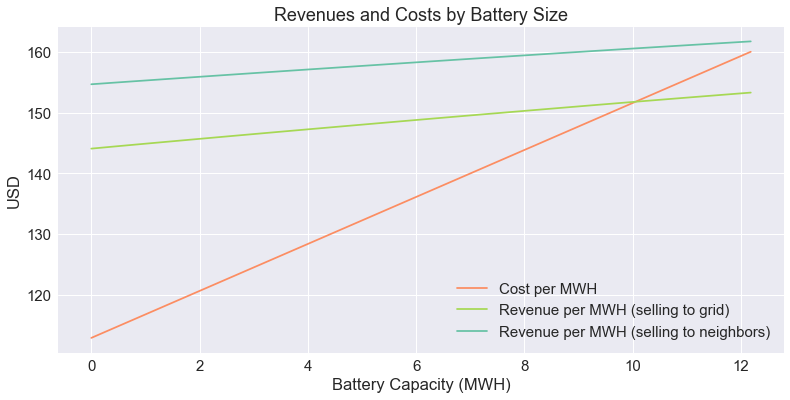

In [26]:
# Plot how batteries of different sizes will impact profits revenues and costs per MWH
plt.figure(figsize=(13, 6))
plt.plot(np.arange(60, step=2)*BATTERY_CAP, costs, label="Cost per MWH", color=palette[1])
plt.plot(np.arange(60, step=2)*BATTERY_CAP, revenues_grid, label='Revenue per MWH (selling to grid)', color=palette[4])
plt.plot(np.arange(60, step=2)*BATTERY_CAP, revenues_neighbors, label='Revenue per MWH (selling to neighbors)', color=palette[0])
plt.title("Revenues and Costs by Battery Size")
plt.xlabel("Battery Capacity (MWH)")
plt.ylabel("USD")
plt.legend(loc='best')
plt.show()

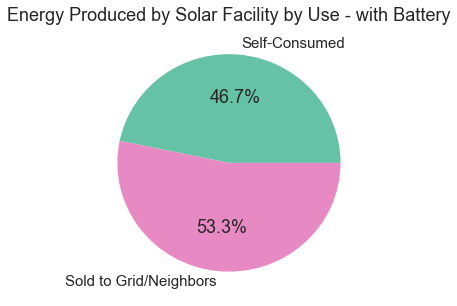

In [27]:
# Pie chart of energy by sale method (with battery)
plt.figure(figsize=(5, 5))
totalselfconsumed = solarstorage8760.agg('sum')['self_consumed_with_battery']
totalsold = solarstorage8760.agg('sum')['excess_with_battery']
pielabels = ['Self-Consumed', 'Sold to Grid/Neighbors']
colors = [palette[0], palette[3]]
plt.pie([totalselfconsumed, totalsold], labels=pielabels, colors = colors, autopct='%1.1f%%',)
plt.title('Energy Produced by Solar Facility by Use - with Battery')
plt.show()

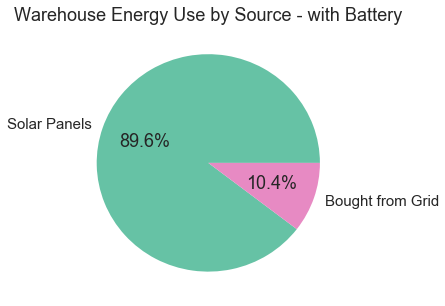

In [28]:
# Pie chart of prologis needs by energy source (with battery)
plt.figure(figsize=(5, 5))
totalselfconsumed = solarstorage8760.agg('sum')['self_consumed_with_battery']
totalsold = solarstorage8760.agg('sum')['debt_with_battery']
pielabels = ['Solar Panels', 'Bought from Grid']
colors = [palette[0], palette[3]]
plt.pie([totalselfconsumed, totalsold], labels=pielabels, colors=colors, autopct='%1.1f%%',)
plt.title('Warehouse Energy Use by Source - with Battery')
plt.show()

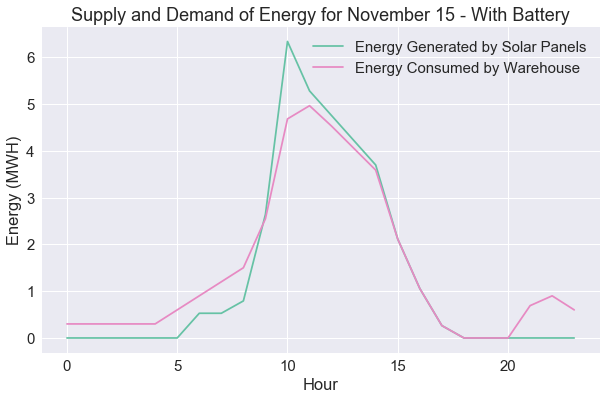

In [29]:
# Graph of daily demand vs supply on Nov 15 (with battery)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(24), solarstorage8760[(solar8760['Month'] == 'Nov') & (solarstorage8760['Day'] == 15)]['Energy'], 
         label='Energy Generated by Solar Panels', color=palette[0])
plt.plot(np.arange(24), solarstorage8760[(solar8760['Month'] == 'Nov') & (solarstorage8760['Day'] == 15)]['Demand'] + 
         solar8760[(solarstorage8760['Month'] == 'Nov') & (solarstorage8760['Day'] == 15)]['battery_storage'] - 
         solar8760[(solarstorage8760['Month'] == 'Nov') & (solarstorage8760['Day'] == 15)]['battery_consumption'],
        label='Energy Consumed by Warehouse', color=palette[3])
plt.legend(loc='best')
plt.xlabel('Hour')
plt.ylabel('Energy (MWH)')
plt.title("Supply and Demand of Energy for November 15 - With Battery")
plt.show()

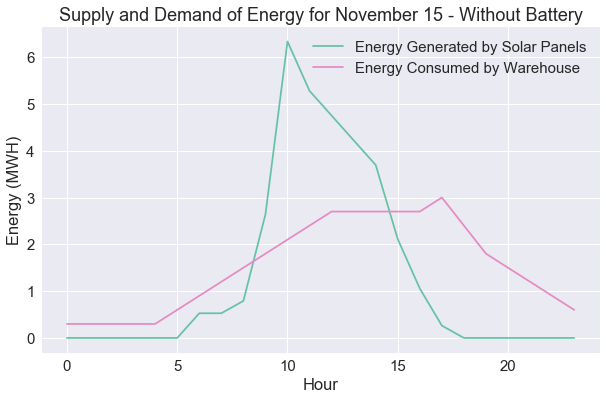

In [30]:
# Graph of supply vs demand on Nov 15 (without battery)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(24), solarstorage8760[(solar8760['Month'] == 'Nov') & (solarstorage8760['Day'] == 15)]['Energy'], 
         label='Energy Generated by Solar Panels', color=palette[0])
plt.plot(np.arange(24), solarstorage8760[(solar8760['Month'] == 'Nov') & (solarstorage8760['Day'] == 15)]['Demand'],
        label='Energy Consumed by Warehouse', color=palette[3])
plt.legend(loc='best')
plt.xlabel('Hour')
plt.ylabel('Energy (MWH)')
plt.title("Supply and Demand of Energy for November 15 - Without Battery")
plt.show()

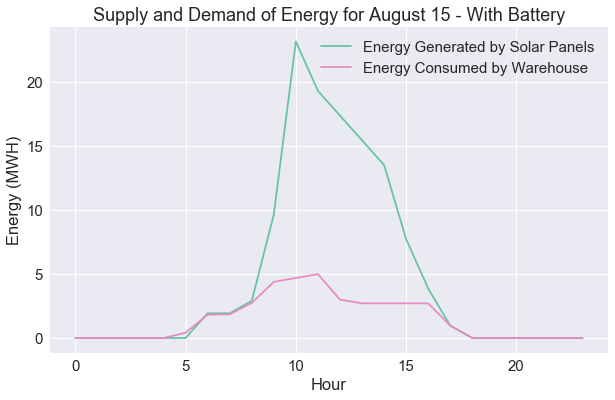

In [31]:
# Graph of demand vs supply on Aug 15 (with battery)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(24), solarstorage8760[(solar8760['Month'] == 'Aug') & (solarstorage8760['Day'] == 15)]['Energy'], 
         label='Energy Generated by Solar Panels', color=palette[0])
plt.plot(np.arange(24), solarstorage8760[(solar8760['Month'] == 'Aug') & (solarstorage8760['Day'] == 15)]['Demand'] + 
         solar8760[(solarstorage8760['Month'] == 'Aug') & (solarstorage8760['Day'] == 15)]['battery_storage'] - 
         solar8760[(solarstorage8760['Month'] == 'Aug') & (solarstorage8760['Day'] == 15)]['battery_consumption'],
        label='Energy Consumed by Warehouse', color=palette[3])
plt.legend(loc='best')
plt.xlabel('Hour')
plt.ylabel('Energy (MWH)')
plt.title("Supply and Demand of Energy for August 15 - With Battery")
plt.show()

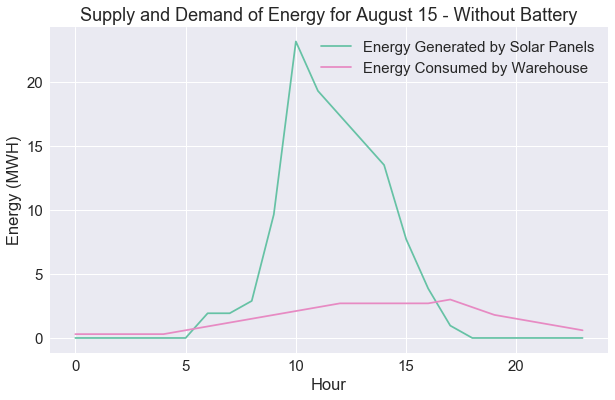

In [32]:
# Graph of demand vs supply on Aug 15 (without battery)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(24), solarstorage8760[(solar8760['Month'] == 'Aug') & (solarstorage8760['Day'] == 15)]['Energy'], 
         label='Energy Generated by Solar Panels', color=palette[0])
plt.plot(np.arange(24), solarstorage8760[(solar8760['Month'] == 'Aug') & (solarstorage8760['Day'] == 15)]['Demand'],
        label='Energy Consumed by Warehouse', color=palette[3])
plt.legend(loc='best')
plt.xlabel('Hour')
plt.ylabel('Energy (MWH)')
plt.title("Supply and Demand of Energy for August 15 - Without Battery")
plt.show()